In [15]:
pip install selenium webdriver-manager beautifulsoup4 requests pymupdf pandas


In [16]:
import os
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
import fitz  # PyMuPDF
from urllib.parse import urljoin

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# -------- CONFIG --------
HEADLESS = False
SAVE_PATH = "kpmg_articles.csv"
MAX_PAGES = 5  # Adjust as needed
# ------------------------

options = Options()
if HEADLESS:
    options.add_argument("--headless=new")
options.add_argument("--start-maximized")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

def extract_article_details(driver, article):
    try:
        driver.get(article["url"])
        time.sleep(4)

        soup = BeautifulSoup(driver.page_source, "html.parser")

        title = soup.find("h1")
        article["title"] = title.get_text(strip=True) if title else article["title"]

        date_tag = soup.find("span", {"id": "heroCsiMonth"})
        article["date_published"] = date_tag.get_text(strip=True) if date_tag else ""

        paragraphs = soup.find_all("p")
        article["content"] = "\n".join([p.get_text(strip=True) for p in paragraphs])

        # Check for PDF link
        pdf_link = None
        for a_tag in soup.find_all("a", href=True):
            href = a_tag['href']
            if href.endswith(".pdf"):
                pdf_link = urljoin(article["url"], href)
                break

        if pdf_link:
            article["pdf_url"] = pdf_link
            try:
                article["pdf_content"] = download_and_extract_pdf(pdf_link)
                print(" PDF extracted.")
            except Exception as e:
                article["pdf_content"] = ""
                print(f" PDF error: {e}")
        else:
            article["pdf_url"] = ""
            article["pdf_content"] = ""

        print(f" Done: {article['title']}")
    except Exception as e:
        print(f" Error processing: {e}")

def download_and_extract_pdf(url):
    response = requests.get(url)
    response.raise_for_status()

    with open("temp.pdf", "wb") as f:
        f.write(response.content)

    doc = fitz.open("temp.pdf")
    text = ""
    for page in doc:
        text += page.get_text()
    doc.close()

    os.remove("temp.pdf")
    return text

# -------- Scrape Multiple Pages --------
base_url = "https://kpmg.com/in/en/insights.html"
driver.get(base_url)
time.sleep(5)

articles = []

for page in range(MAX_PAGES):
    print(f"\n📄 Collecting Page {page + 1}...")

    time.sleep(3)
    tiles = driver.find_elements(By.CLASS_NAME, "cmp-filterlist__tile")
    for tile in tiles:
        try:
            title = tile.find_element(By.CLASS_NAME, "cmp-filterlist__tile--title").text
            link = tile.find_element(By.TAG_NAME, "a").get_attribute("href")
            if link not in [a["url"] for a in articles]:
                articles.append({"title": title, "url": link})
        except Exception as e:
            print(" Tile error:", e)

    print(f" Articles so far: {len(articles)}")

    try:
        next_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "button[aria-label='Next set of results']"))
        )
        driver.execute_script("arguments[0].click();", next_button)
    except Exception as e:
        print("No more pages or failed to click next:", e)
        break

# -------- Extract Article Data --------
for article in articles:
    extract_article_details(driver, article)

driver.quit()

# -------- Save to CSV --------
df = pd.DataFrame(articles)
df.to_csv(SAVE_PATH, index=False)
print(f"\n All done. Saved to: {SAVE_PATH}")



📄 Collecting Page 1...
 Articles so far: 8

📄 Collecting Page 2...
 Articles so far: 16

📄 Collecting Page 3...
 Articles so far: 24

📄 Collecting Page 4...
 Articles so far: 32

📄 Collecting Page 5...
 Articles so far: 40
 Done: U.S. tariffs: How can India redraw the trade map for its chemical exports?
 Done: India CX Report'25: Retail
 Done: India CX Report'25: E-Pharmacy
 Done: India CX Report'25: Grocery
 Done: India CX Report'25: Electronic stores
 Done: India CX Report'25: Apparel
 Done: India CX Report'25: Fine Jewellery
 Done: India CX Report'25: Quick Service Restaurant (QSR)
 PDF extracted.
 Done: Applying detection engineering to business applications
 Done: Energy and natural resources sector
 PDF extracted.
 Done: Decoding Indian economy
 Done: From Sky to Screen: Satellite Communications – India’s Next Digital Leap
 Done: India CX Report'25: Automotive
 Done: India CX Report'25: Commercial vehicles
 Done: India CX Report'25: Passenger vehicles
 Done: India CX Report'25: 

In [17]:
import pandas as pd 

df = pd.read_csv(("kpmg_articles.csv"))

#view the first few rows
print(df.head())

                                               title  \
0  U.S. tariffs: How can India redraw the trade m...   
1                         India CX Report'25: Retail   
2                     India CX Report'25: E-Pharmacy   
3                        India CX Report'25: Grocery   
4              India CX Report'25: Electronic stores   

                                                 url date_published  \
0  https://kpmg.com/in/en/blogs/2025/05/us-tariff...   16 May, 2025   
1  https://kpmg.com/in/en/insights/2025/03/india-...            NaN   
2  https://kpmg.com/in/en/insights/2025/03/india-...            NaN   
3  https://kpmg.com/in/en/insights/2025/03/india-...            NaN   
4  https://kpmg.com/in/en/insights/2025/03/india-...            NaN   

                                             content pdf_url pdf_content  
0  \nTransformation\nArtificial Intelligence\nHow...     NaN         NaN  
1  \nTransformation\nArtificial Intelligence\nHow...     NaN         NaN  
2  \nTransf

In [18]:
# #  Get the 4th column (index 3) of the first row (index 0)
# content_column = df.iloc[0, 3]

# # Display content column
# print(first_content)

In [19]:
# Get content (4th column) and pdf_content (6th column) from row 11
# row_11_content = df.iloc[10, 3]       # Column index 3 = 'content'
# row_11_pdf_content = df.iloc[10, 5]   # Column index 5 = 'pdf_content'

# # Display the values
# print("📄 Content:\n", row_11_content)
# print("\n📎 PDF Content:\n", row_11_pdf_content)

## Part 2

# 1. Preprocessing – Clean & Normalize the Text

In [20]:
!pip install pandas scikit-learn nltk spacy keybert sentence-transformers
!python -m nltk.downloader stopwords punkt
!python -m spacy download en_core_web_sm


  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<f

In [21]:
# ---- Imports ----
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import umap
import hdbscan

# ---- Load and Combine Text ----
df = pd.read_csv("kpmg_articles.csv")
df["full_text"] = df["content"].fillna("") + " " + df["pdf_content"].fillna("")

# ---- Text Cleaning ----
custom_stopwords = set("a an the and is in it for to of with on that this as by at from or be are".split())

def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]", " ", text)
    tokens = re.findall(r'\b\w{3,}\b', text.lower())
    filtered = [word for word in tokens if word not in custom_stopwords]
    return " ".join(filtered)

df["clean_text"] = df["full_text"].apply(clean_text)

# ---- Rule-based Topic Classification ----
topic_keywords = {
    "ESG": ["esg", "sustainability", "carbon", "net zero"],
    "Supply Chain": ["logistics", "supply chain", "inventory"],
    "Cyber security": ["cyber", "security", "ransomware", "hacking"],
    "Workforce": ["employee", "workforce", "hr", "talent", "hiring"],
    "Artificial Intelligence": ["ai", "artificial intelligence", "machine learning"],
    "Technology": ["technology", "digital", "software", "platform"],
    "Risk and Regulation": ["regulation", "compliance", "risk", "policy"],
    "Transformation": ["transformation", "change", "innovation"],
    "GCC": ["gcc", "global capability center", "shared service"],
    "Economy and Growth": ["gdp", "economy", "growth", "inflation"],
    "Energy and Renewables": ["solar", "wind", "renewables", "energy"],
    "Trade and tariffs": ["trade", "tariff", "exports", "imports"],
}

def classify_topic(text):
    for topic, keywords in topic_keywords.items():
        if any(kw in text.lower() for kw in keywords):
            return topic
    return "Other"

df["topic"] = df["clean_text"].apply(classify_topic)

# ---- TF-IDF Keyword Extraction ----
tfidf = TfidfVectorizer(max_features=50)
X_tfidf = tfidf.fit_transform(df["clean_text"])
keywords = tfidf.get_feature_names_out()
top_indices = X_tfidf.toarray().argsort(axis=1)[:, -5:]

top_keywords = []
for row in top_indices:
    words = [keywords[i] for i in row if i < len(keywords)]
    top_keywords.append(words)
df["top_keywords"] = top_keywords

# ---- Semantic Topic Classification ----
semantic_topics = list(topic_keywords.keys())
model = SentenceTransformer("all-MiniLM-L6-v2")
topic_embeddings = model.encode(semantic_topics)
article_embeddings = model.encode(df["clean_text"].tolist())

def classify_semantic(embedding):
    sims = cosine_similarity([embedding], topic_embeddings)[0]
    return semantic_topics[np.argmax(sims)]

df["classified_topic"] = [classify_semantic(e) for e in article_embeddings]

# ---- UMAP + HDBSCAN Clustering ----
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(article_embeddings)

cluster_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
df["cluster"] = cluster_model.fit_predict(umap_embeddings)

# ---- Extract Cluster Keywords ----
def extract_keywords(texts, top_n=5):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    top_keywords = X.toarray().mean(axis=0).argsort()[::-1][:top_n]
    return [keywords[i] for i in top_keywords]

cluster_labels = {}
for c in sorted(df["cluster"].unique()):
    cluster_texts = df[df["cluster"] == c]["clean_text"].tolist()
    cluster_labels[c] = extract_keywords(cluster_texts)

df["cluster_keywords"] = df["cluster"].map(cluster_labels)

# ---- Save Enriched Data ----
df.to_csv("kpmg_articles_enriched.csv", index=False)
print("✅ Enriched data saved to kpmg_articles_enriched.csv")


C:\Users\prana\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\prana\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Enriched data saved to kpmg_articles_enriched.csv


In [22]:
pip install umap-learn hdbscan scikit-learn


  Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp312-cp312-win_amd64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


# Part 3

# 1.  Key Industries Covered by KPMG

In [23]:
!pip install wordcloud

  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


C:\Users\prana\AppData\Local\Temp\ipykernel_16908\2617071447.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="classified_topic", order=df["classified_topic"].value_counts().index, palette="viridis")


 Total Articles: 40
 Unique Topics: 10
 Unique Clusters: 2

 Topic Distribution:
classified_topic
Supply Chain               18
Workforce                   5
Risk and Regulation         4
Cyber security              3
Transformation              3
Trade and tariffs           2
Economy and Growth          2
Technology                  1
Energy and Renewables       1
Artificial Intelligence     1
Name: count, dtype: int64

 Top Keywords: [('you', 29), ('kpmg', 26), ('cookies', 26), ('not', 23), ('these', 16), ('customer', 16), ('experience', 9), ('entities', 8), ('india', 5), ('clients', 5)]


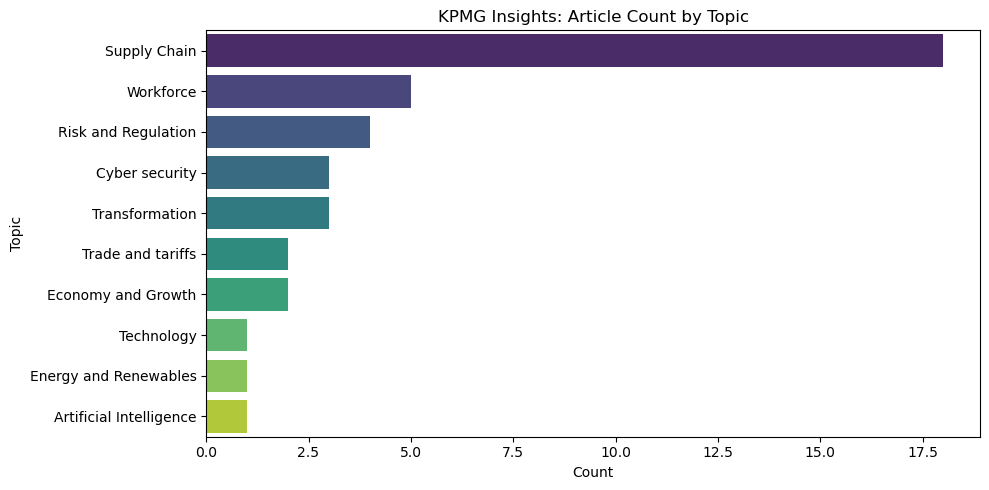

C:\Users\prana\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\prana\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


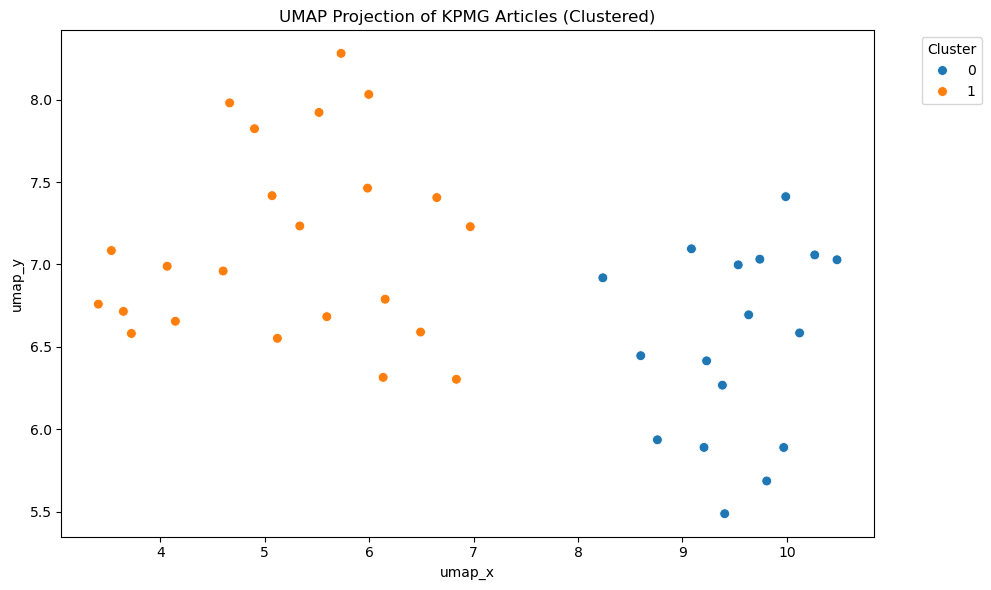

In [24]:
# ---- Imports ----
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast

# ---- Load Enriched Data ----
df = pd.read_csv("kpmg_articles_enriched.csv")

# Ensure list columns are interpreted correctly
df["top_keywords"] = df["top_keywords"].apply(ast.literal_eval)
df["cluster_keywords"] = df["cluster_keywords"].apply(ast.literal_eval)

# ---- Summary Statistics ----
print(" Total Articles:", len(df))
print(" Unique Topics:", df["classified_topic"].nunique())
print(" Unique Clusters:", df["cluster"].nunique())
print("\n Topic Distribution:")
print(df["classified_topic"].value_counts())

# ---- Top 10 Keywords in Corpus ----
from collections import Counter
keyword_counts = Counter([kw for kws in df["top_keywords"] for kw in kws])
print("\n Top Keywords:", keyword_counts.most_common(10))

# ---- Topic Frequency Bar Plot ----
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y="classified_topic", order=df["classified_topic"].value_counts().index, palette="viridis")
plt.title("KPMG Insights: Article Count by Topic")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

# ---- Cluster Embedding Visualization (UMAP) ----
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# If UMAP embeddings not saved, re-compute
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["clean_text"].tolist(), show_progress_bar=True)

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_proj = umap_model.fit_transform(embeddings)

df["umap_x"] = umap_proj[:, 0]
df["umap_y"] = umap_proj[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="umap_x", y="umap_y", hue="cluster", palette="tab10", s=50)
plt.title("UMAP Projection of KPMG Articles (Clustered)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---- WordCloud for Cluster Topics ----
def show_wordcloud(cluster_id):
    keywords = df[df["cluster"] == cluster_id]["cluster_keywords"].explode().dropna().tolist()
    if not keywords:
        print("No keywords found for this cluster.")
        return
    text = " ".join(keywords)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for Cluster {cluster_id}")
    plt.show()

